In [193]:
from collections import defaultdict, namedtuple, Counter
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats


In [196]:
#phase_dir = '../phased_ihart.ms2_quads'
#phase_dir = '../phased_ssc.hg38'
#phase_dir = '../phased_mssng_quads'
phase_dir = '../phased_spark_quads'
#phase_dir = '../phased_ancestry_quads'

#phase_dir = '../sibpair_wgs'

build = '38'
phenotype = ''

chroms = [str(x) for x in range(1, 23)]
interval = 500000


In [197]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr') and pieces[0][3:] in chroms:
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

chrom_to_start_pos = [1]
for chrom in chroms[:-1]:
    chrom_length = max([x[2] for x in cyto if x[0]==chrom])
    chrom_to_start_pos.append(chrom_to_start_pos[-1] + chrom_length)
    

In [198]:
all_chroms, all_regions = [], []
pvalues = []
contingency = []
for i, chrom in enumerate(chroms):
    regions = np.load('%s/chr.%s.IST.pvalues.be.%sintervals.%d.regions.npy' % (phase_dir, chrom, phenotype, interval))
    all_chroms.append(i*np.ones((regions.shape[0]-1,), dtype=int))
    all_regions.append(np.vstack((regions[:-1], regions[1:])))
    pvalues.append(np.load('%s/chr.%s.IST.pvalues.be.%sintervals.%d.npy' % (phase_dir, chrom, phenotype, interval)))
    contingency.append(np.load('%s/chr.%s.IST.pvalues.be.%sintervals.%d.contingency.npy' % (phase_dir, chrom, phenotype, interval)))
all_chroms = np.hstack(all_chroms)
all_regions = np.hstack(all_regions).T
pvalues = np.vstack(pvalues)
contingency = np.vstack(contingency)

print(all_regions.shape, pvalues.shape, all_chroms.shape, contingency.shape)


(5760, 2) (5760, 6) (5760,) (5760, 3, 2)


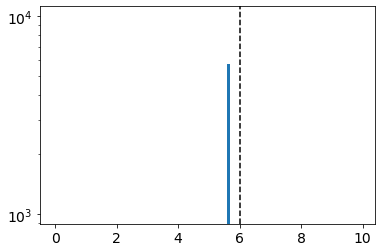

In [199]:
cutoff = 1000000
plt.hist(np.log10(all_regions[:, 1]-all_regions[:, 0]), 
         log=True, bins=np.arange(0, 10, 0.1))
plt.axvline(np.log10(cutoff), color='black', linestyle='--')
plt.show()

In [200]:
#include_in_display = np.zeros(all_positions.shape, dtype=bool)
#include_in_display[0] = True
#last_pos = all_positions[0]
#for i, pos in enumerate(all_positions):
#    if np.abs(pos - last_pos) > cutoff:
#        include_in_display[i] = True
#        last_ps = pos

include_in_display = np.ones((all_regions.shape[0]), dtype=bool)
#for c in cyto:
#    if c[0] in chroms and c[-1] == 'acen':
#        include_in_display[(all_chroms==chroms.index(c[0])) & (np.minimum(all_regions[:, 1], c[2])-np.maximum(all_regions[:, 0], c[1])>0)]=False
print('including', np.sum(include_in_display)/include_in_display.shape[0])



including 1.0


In [201]:
bonferonni_cutoff = -np.log10(0.05/(2*np.sum(include_in_display)))
print(bonferonni_cutoff)

5.362482474751174


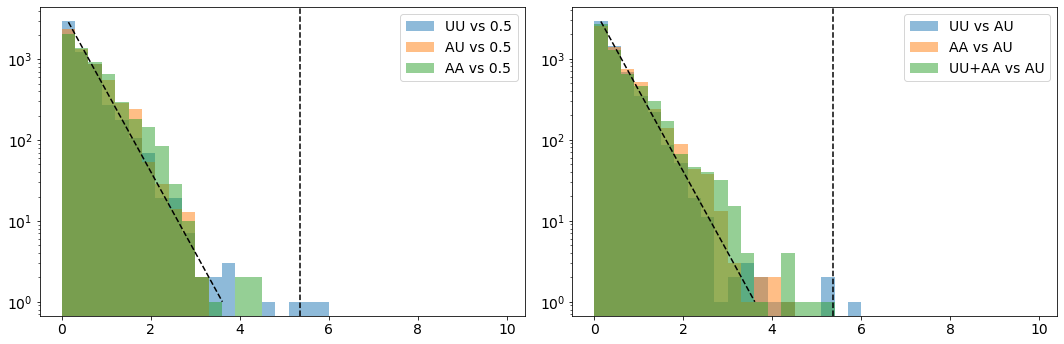

In [202]:
binsize = 0.3
x_chrom = -1 if 'X' not in chroms else chroms.index('X')
n = np.sum(include_in_display & (all_chroms != x_chrom))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 0]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='UU vs 0.5')
plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 1]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='AU vs 0.5')
plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 2]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='AA vs 0.5')
plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
             [n*(1-(10**-binsize)), 1], color='black', linestyle='--')  
plt.axvline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend()
    
plt.subplot(1, 2, 2)

plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 3]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='UU vs AU')
plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 4]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='AA vs AU')
plt.hist(np.clip(-np.log10(pvalues[include_in_display & (all_chroms != x_chrom), 5]), None, 9), 
                     log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label='UU+AA vs AU')
        
plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
             [n*(1-(10**-binsize)), 1], color='black', linestyle='--')  
plt.axvline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend()


plt.tight_layout()
plt.show()

In [203]:
xs = np.array([p+chrom_to_start_pos[c] for p, c in zip(all_regions[:, 0], all_chroms)])


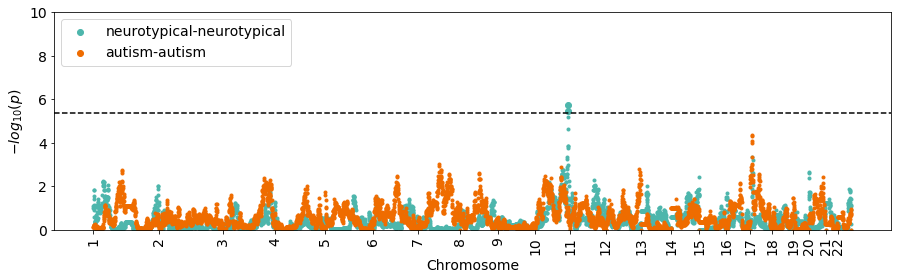

In [204]:
import matplotlib
plt.figure(figsize=(15, 4))
matplotlib.rcParams.update({'font.size': 14})

labels = ['neurotypical-neurotypical', 'P[AUshare]<0.5', 'autism-autism', 
          'P[UUshare]>P[AUshare]', 'P[AAshare]>P[AUshare]', 'P[UUshare+AAshare]>P[AUshare]',
         'P[UUshare+AAshare]>0.5']

colors = ['#4db6acff', None, '#ef6c00ff']

for index in [0, 2]:
    indices = include_in_display
    plt.scatter(xs[indices], -np.log10(pvalues[indices, index]), marker='.', color=colors[index])
    indices = include_in_display & (-np.log10(pvalues[include_in_display, index])>bonferonni_cutoff)
    plt.scatter(xs[indices], -np.log10(pvalues[indices, index]), label=labels[index], color=colors[index])
    plt.ylim([0, 10])

plt.xticks(chrom_to_start_pos, chroms, rotation=90)
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.show()

In [186]:
#print('simplex combined')
#indices = -np.log10(simplex_combined_pvalues)>bonferonni_cutoff
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))

#print('\nmultiplex combined')
#indices = -np.log10(multiplex_combined_pvalues)>bonferonni_cutoff
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))

indices = np.any(-np.log10(pvalues)>bonferonni_cutoff, axis=1)
print(np.sum(indices))
start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+2
for start_index, end_index in zip(start_indices, end_indices):
    if all_chroms[start_index] == all_chroms[end_index]:
        print(start_index, end_index, -np.log10(pvalues[start_index, 0]), -np.log10(pvalues[end_index, 0]), pvalues[start_index, 0]*2*np.sum(include_in_display), pvalues[end_index, 0]*2*np.sum(include_in_display))
        print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))
    
#print('\nmultiplex pat')
#indices = -np.log10(multiplex_pat_pvalues)>bonferonni_cutoff-0.5
#start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
#for start_index, end_index in zip(start_indices, end_indices):
#    print('%s:%d-%d (hg%s)' % (chroms[all_chroms[start_index]], all_regions[start_index, 0], all_regions[end_index, 1], build))


0


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


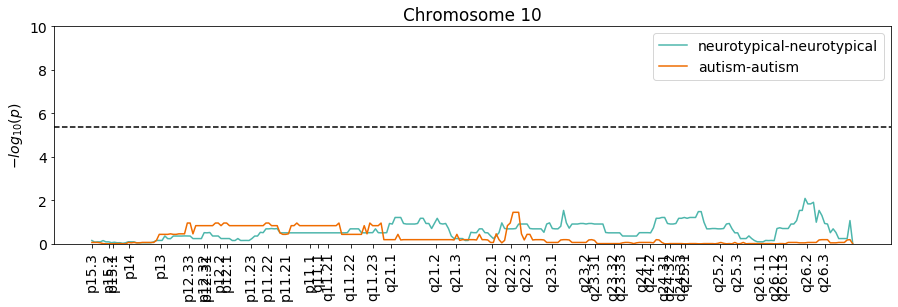

In [187]:
import matplotlib


chrom = '10'
chrom_index = chroms.index(chrom)


plt.figure(figsize=(15, 4))


for index in [0, 2]:
    #ax = plt.subplot(3, 1, index+1)
    plt.plot(xs[include_in_display & (all_chroms == chrom_index)], -np.log10(pvalues[include_in_display & (all_chroms == chrom_index), index]), label=labels[index], color=colors[index])

plt.ylim([0, 10])
plt.xticks([chrom_to_start_pos[chrom_index]+x[1] for x in cyto if x[0]==chrom], 
       [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.legend()
plt.title('Chromosome %s' % chrom)
plt.ylabel('$-log_{10}(p)$')
#plt.tight_layout()
plt.show()


In [188]:
print(all_regions.shape)

(5776, 2)


In [189]:
if build == '37':
    start_pos, end_pos = 127188569, 127688569
elif build == '38':
    start_pos, end_pos = 125500000, 126000000

regions_of_interest = np.where((all_chroms==9) & (np.minimum(all_regions[:, 1], end_pos)-np.maximum(all_regions[:, 0], start_pos)>0))[0]
region_of_interest = regions_of_interest[0]
print(regions_of_interest)
print(pvalues[regions_of_interest, :])
print((np.minimum(all_regions[:, 1], end_pos)-np.maximum(all_regions[:, 0], start_pos))[regions_of_interest])
print(contingency[region_of_interest, 0, :])
print(contingency[region_of_interest, 0, 0]/contingency[region_of_interest, 0, 1])


[3620 3621]
[[0.0080624  0.63282898 0.890625   0.06309282 0.67181432 0.18164612]
 [0.01440836 0.63449556 0.85546875 0.10823532 0.71011923 0.26314593]]
[311431 188569]
[22. 30.]
0.7333333333333333


In [192]:
n = contingency[region_of_interest, 0, 1]
p_hat = contingency[region_of_interest, 0, 0]/n
z = 1.96
wilson_lower_conf = (2*n*p_hat + z**2 - (z*np.sqrt(z**2 - (1/n) + 4*n*p_hat*(1-p_hat) + (4*p_hat - 2)) + 1))/(2*(n+z**2))
wilson_upper_conf = (2*n*p_hat + z**2 + (z*np.sqrt(z**2 - (1/n) + 4*n*p_hat*(1-p_hat) + (4*p_hat - 2)) + 1))/(2*(n+z**2))
print(p_hat, wilson_lower_conf, wilson_upper_conf)

# from spark
p_hat, wilson_lower_conf, wilson_upper_conf = 0.6807228915662651, 0.6032887469766876, 0.7499815943295649
print(p_hat, wilson_lower_conf, wilson_upper_conf)

0.7333333333333333 0.5382687992491173 0.8754232247686596
0.6807228915662651 0.6032887469766876 0.7499815943295649


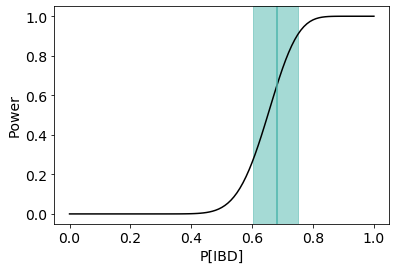

In [144]:
# power calculation
# null hypothesis is that p=0.5
# one-sided test

n = 18*2
alpha = 0.05
p = np.arange(0, 1.01, 0.01)

cutoffs = np.arange(0, n+1)
cdf = stats.binom.cdf(cutoffs, n, 0.5)
cutoff = cutoffs[np.argmax(cdf>=(1-alpha))]

#plt.figure(figsize=(15, 5))
#plt.subplot(1, 2, 1)
#plt.plot(cdf)
#plt.axvline(cutoff, color='black')
#print(cutoff)

#plt.subplot(1, 2, 2)
ps = np.arange(0, 1.01, 0.01)
power = 1-stats.binom.cdf(cutoff, n, ps)
plt.plot(ps, power, color='black', label='n=18')

plt.axvline(p_hat, color=colors[0], label='SPARK estimate')
plt.axvspan(wilson_lower_conf, wilson_upper_conf, alpha=0.5, color=colors[0])
plt.xlabel('P[IBD]')
plt.ylabel('Power')
#plt.legend()

plt.show()

#print(stats.binom.(0.5, ))

In [145]:
print(power[np.searchsorted(ps, p_hat)])


0.6913596305720711
